In [1]:
import pandas as pd
import gensim as gs
import numpy as np
import pickle
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import Stemmer
from sentence_transformers import SentenceTransformer
from tqdm.autonotebook import tqdm

from gensim.corpora import Dictionary
from gensim.models import TfidfModel, OkapiBM25Model
from gensim.similarities import SparseMatrixSimilarity

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Stamina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Read dataset, original to be used in BERT - processed to be used in BM25

original_df = pd.read_pickle("processed_dataset/dataset_qdpairs_raw.pkl")
processed_df = pd.read_pickle("processed_dataset/dataset_qdpairs_processed.pkl")

In [3]:
# Load up BM25 pickles

corpus = pickle.load(open('gensim_bm25_pickles/corpus.pkl', 'rb'))
dictionary = pickle.load(open('gensim_bm25_pickles/dictionary.pkl', 'rb'))
bm25_model = pickle.load(open('gensim_bm25_pickles/bm25_model.pkl', 'rb'))
bm25_corpus = pickle.load(open('gensim_bm25_pickles/bm25_corpus.pkl', 'rb'))
bm25_index = pickle.load(open('gensim_bm25_pickles/bm25_index.pkl', 'rb'))

In [4]:
# Load up BERTurk model and pre-computed document embeddings

model = SentenceTransformer('emrecan/bert-base-turkish-cased-mean-nli-stsb-tr')
model.max_seq_length = 512
model.to('cuda')

doc_embeddings = np.load('doc_embeddings_npy/doc_embeddings.npy')

In [15]:
from sklearn.preprocessing import MinMaxScaler
# Define the function for preprocessing query for BM25

def preprocess_str(str_to_process):
    # This is a turkish stemmer, doesn't work perfect but it is consistent at least
    stemmer = Stemmer.Stemmer('turkish')
    
    str_result = str_to_process
    # Remove non-chars
    str_result = gs.parsing.preprocessing.strip_multiple_whitespaces(gs.parsing.preprocessing.strip_numeric(gs.parsing.preprocessing.strip_non_alphanum(str_result)))
    # Lowercase str
    str_result = str_result.lower()
    # Remove stopwords
    str_result = gs.parsing.preprocessing.remove_stopwords(s=str_result, stopwords=stopwords.words("turkish"))
    # Split str
    str_result = str_result.split()
    # Stem words
    str_result = stemmer.stemWords(str_result)

    return str_result

# Define functions for scoring each document given query

def score_multiple_weights(int_index, weight_combinations):

    query_bm25 = processed_df.iloc[int_index].query
    query_bert = original_df.iloc[int_index].query

    bm25_scores = score_BM25(query_bm25, False)
    bert_scores = score_BERT(query_bert)

    bm25_scores = [score for score, _ in bm25_scores]
    bert_scores = [score for score, _ in bert_scores]

    # Normalize the scores using MinMaxScaler
    scaler = MinMaxScaler()
    bm25_scores_normalized = scaler.fit_transform(np.array(bm25_scores).reshape(-1, 1))
    bert_scores_normalized = scaler.fit_transform(np.array(bert_scores).reshape(-1, 1))

    results = []

    for i in range(len(weight_combinations)):
        weights = weight_combinations[i]

        weight_bm25 = weights[0] / (weights[0] + weights[1])
        weight_bert = weights[1] / (weights[0] + weights[1])

        average_scores = weight_bm25 * bm25_scores_normalized + weight_bert * bert_scores_normalized

        sorted_indices = np.argsort(average_scores.flatten())[::-1]

        resulting_idx = np.where(sorted_indices == int_index)[0][0] + 1

        results.append(resulting_idx)

    return results

def score(query, weights = [0.5, 0.5], is_index = False):

    weight_bm25 = weights[0] / (weights[0] + weights[1])
    weight_bert = weights[1] / (weights[0] + weights[1])

    query_bm25 = query if not is_index else processed_df.loc[query].query
    query_bert = query if not is_index else original_df.loc[query].query

    bm25_scores = score_BM25(query_bm25, not is_index)
    bert_scores = score_BERT(query_bert)

    bm25_scores = [score for score, _ in bm25_scores]
    bert_scores = [score for score, _ in bert_scores]

    # Normalize the scores using MinMaxScaler
    scaler = MinMaxScaler()
    bm25_scores_normalized = scaler.fit_transform(np.array(bm25_scores).reshape(-1, 1))
    bert_scores_normalized = scaler.fit_transform(np.array(bert_scores).reshape(-1, 1))

    # Average the normalized scores
    average_scores = weight_bm25 * bm25_scores_normalized + weight_bert * bert_scores_normalized

    # Combine the average scores with the document indices
    final_scores = sorted(zip(average_scores.flatten(), processed_df.index), reverse=True)

    return final_scores
    

def score_BM25(query, preprocess = True):
    preprocessed_query = preprocess_str(query) if preprocess else query
    tfidf_model = TfidfModel(dictionary=dictionary, smartirs='bnn')  # Enforce binary weighting of queries
    tfidf_query = tfidf_model[dictionary.doc2bow(preprocessed_query)]
    
    similarities = bm25_index[tfidf_query]

    scores = [(similarity, index) for similarity, index in zip(similarities, processed_df.index)]
    # scores = sorted(zip(similarities, processed_df.index), reverse=True)

    return scores

def score_BERT(query):
    query_embedding = model.encode(query, normalize_embeddings=True)

    similarities = np.dot(doc_embeddings, query_embedding.T)

    scores = [(similarity, index) for similarity, index in zip(similarities, original_df.index)]
    # scores = sorted(zip(similarities, original_df.index), reverse=True)

    return scores

In [136]:
sample_amount = 5000
weight_combinations = [[1.0, 0.0], [0.9, 0.1], [0.8, 0.2], [0.7, 0.3], [0.6, 0.4], [0.5, 0.5], [0.4, 0.6], [0.3, 0.7], [0.2, 0.8], [0.1, 0.9], [0.0, 1.0]]

random_indices = np.random.choice(range(processed_df.shape[0]), size=sample_amount, replace=False)

results = []

for index in random_indices:
    results.append(score_multiple_weights(index, weight_combinations))

results = np.array(results)

In [137]:
combination_mean_results = np.array(results).mean(axis=0)

for i, combination in enumerate(weight_combinations):
    print(f'Average ranking obtained for weight combination {combination} is {combination_mean_results[i]}')

Average ranking obtained for weight combination [1.0, 0.0] is 52939.5802
Average ranking obtained for weight combination [0.9, 0.1] is 50381.014
Average ranking obtained for weight combination [0.8, 0.2] is 47776.4422
Average ranking obtained for weight combination [0.7, 0.3] is 45182.0098
Average ranking obtained for weight combination [0.6, 0.4] is 42631.3534
Average ranking obtained for weight combination [0.5, 0.5] is 40197.8196
Average ranking obtained for weight combination [0.4, 0.6] is 37993.1752
Average ranking obtained for weight combination [0.3, 0.7] is 36216.0986
Average ranking obtained for weight combination [0.2, 0.8] is 35138.9826
Average ranking obtained for weight combination [0.1, 0.9] is 35022.2146
Average ranking obtained for weight combination [0.0, 1.0] is 36158.2076


In [138]:
top_10_accuracies = (results < 10).mean(axis=0)
top_100_accuracies = (results < 100).mean(axis=0)
top_1000_accuracies = (results < 1000).mean(axis=0)

print(top_10_accuracies)
print(top_100_accuracies)
print(top_1000_accuracies)

[0.1932 0.1994 0.2034 0.21   0.2136 0.2096 0.201  0.1888 0.1676 0.138
 0.0938]
[0.2866 0.2954 0.303  0.311  0.3168 0.3194 0.3186 0.3064 0.2796 0.2406
 0.1844]
[0.4218 0.4362 0.4468 0.458  0.4654 0.4684 0.4706 0.4606 0.4398 0.4036
 0.3504]


In [147]:
import numpy as np

diagonal_values = [0.2866, 0.2954, 0.303, 0.311, 0.3168, 0.3194, 0.3186, 0.3064, 0.2796, 0.2406, 0.1844]
table_size = len(diagonal_values)

table = np.zeros((table_size, table_size))
np.fill_diagonal(table[::-1], diagonal_values)

print(table)


[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.1844]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.2406
  0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.2796 0.
  0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.3064 0.     0.
  0.    ]
 [0.     0.     0.     0.     0.     0.     0.3186 0.     0.     0.
  0.    ]
 [0.     0.     0.     0.     0.     0.3194 0.     0.     0.     0.
  0.    ]
 [0.     0.     0.     0.     0.3168 0.     0.     0.     0.     0.
  0.    ]
 [0.     0.     0.     0.311  0.     0.     0.     0.     0.     0.
  0.    ]
 [0.     0.     0.303  0.     0.     0.     0.     0.     0.     0.
  0.    ]
 [0.     0.2954 0.     0.     0.     0.     0.     0.     0.     0.
  0.    ]
 [0.2866 0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.    ]]


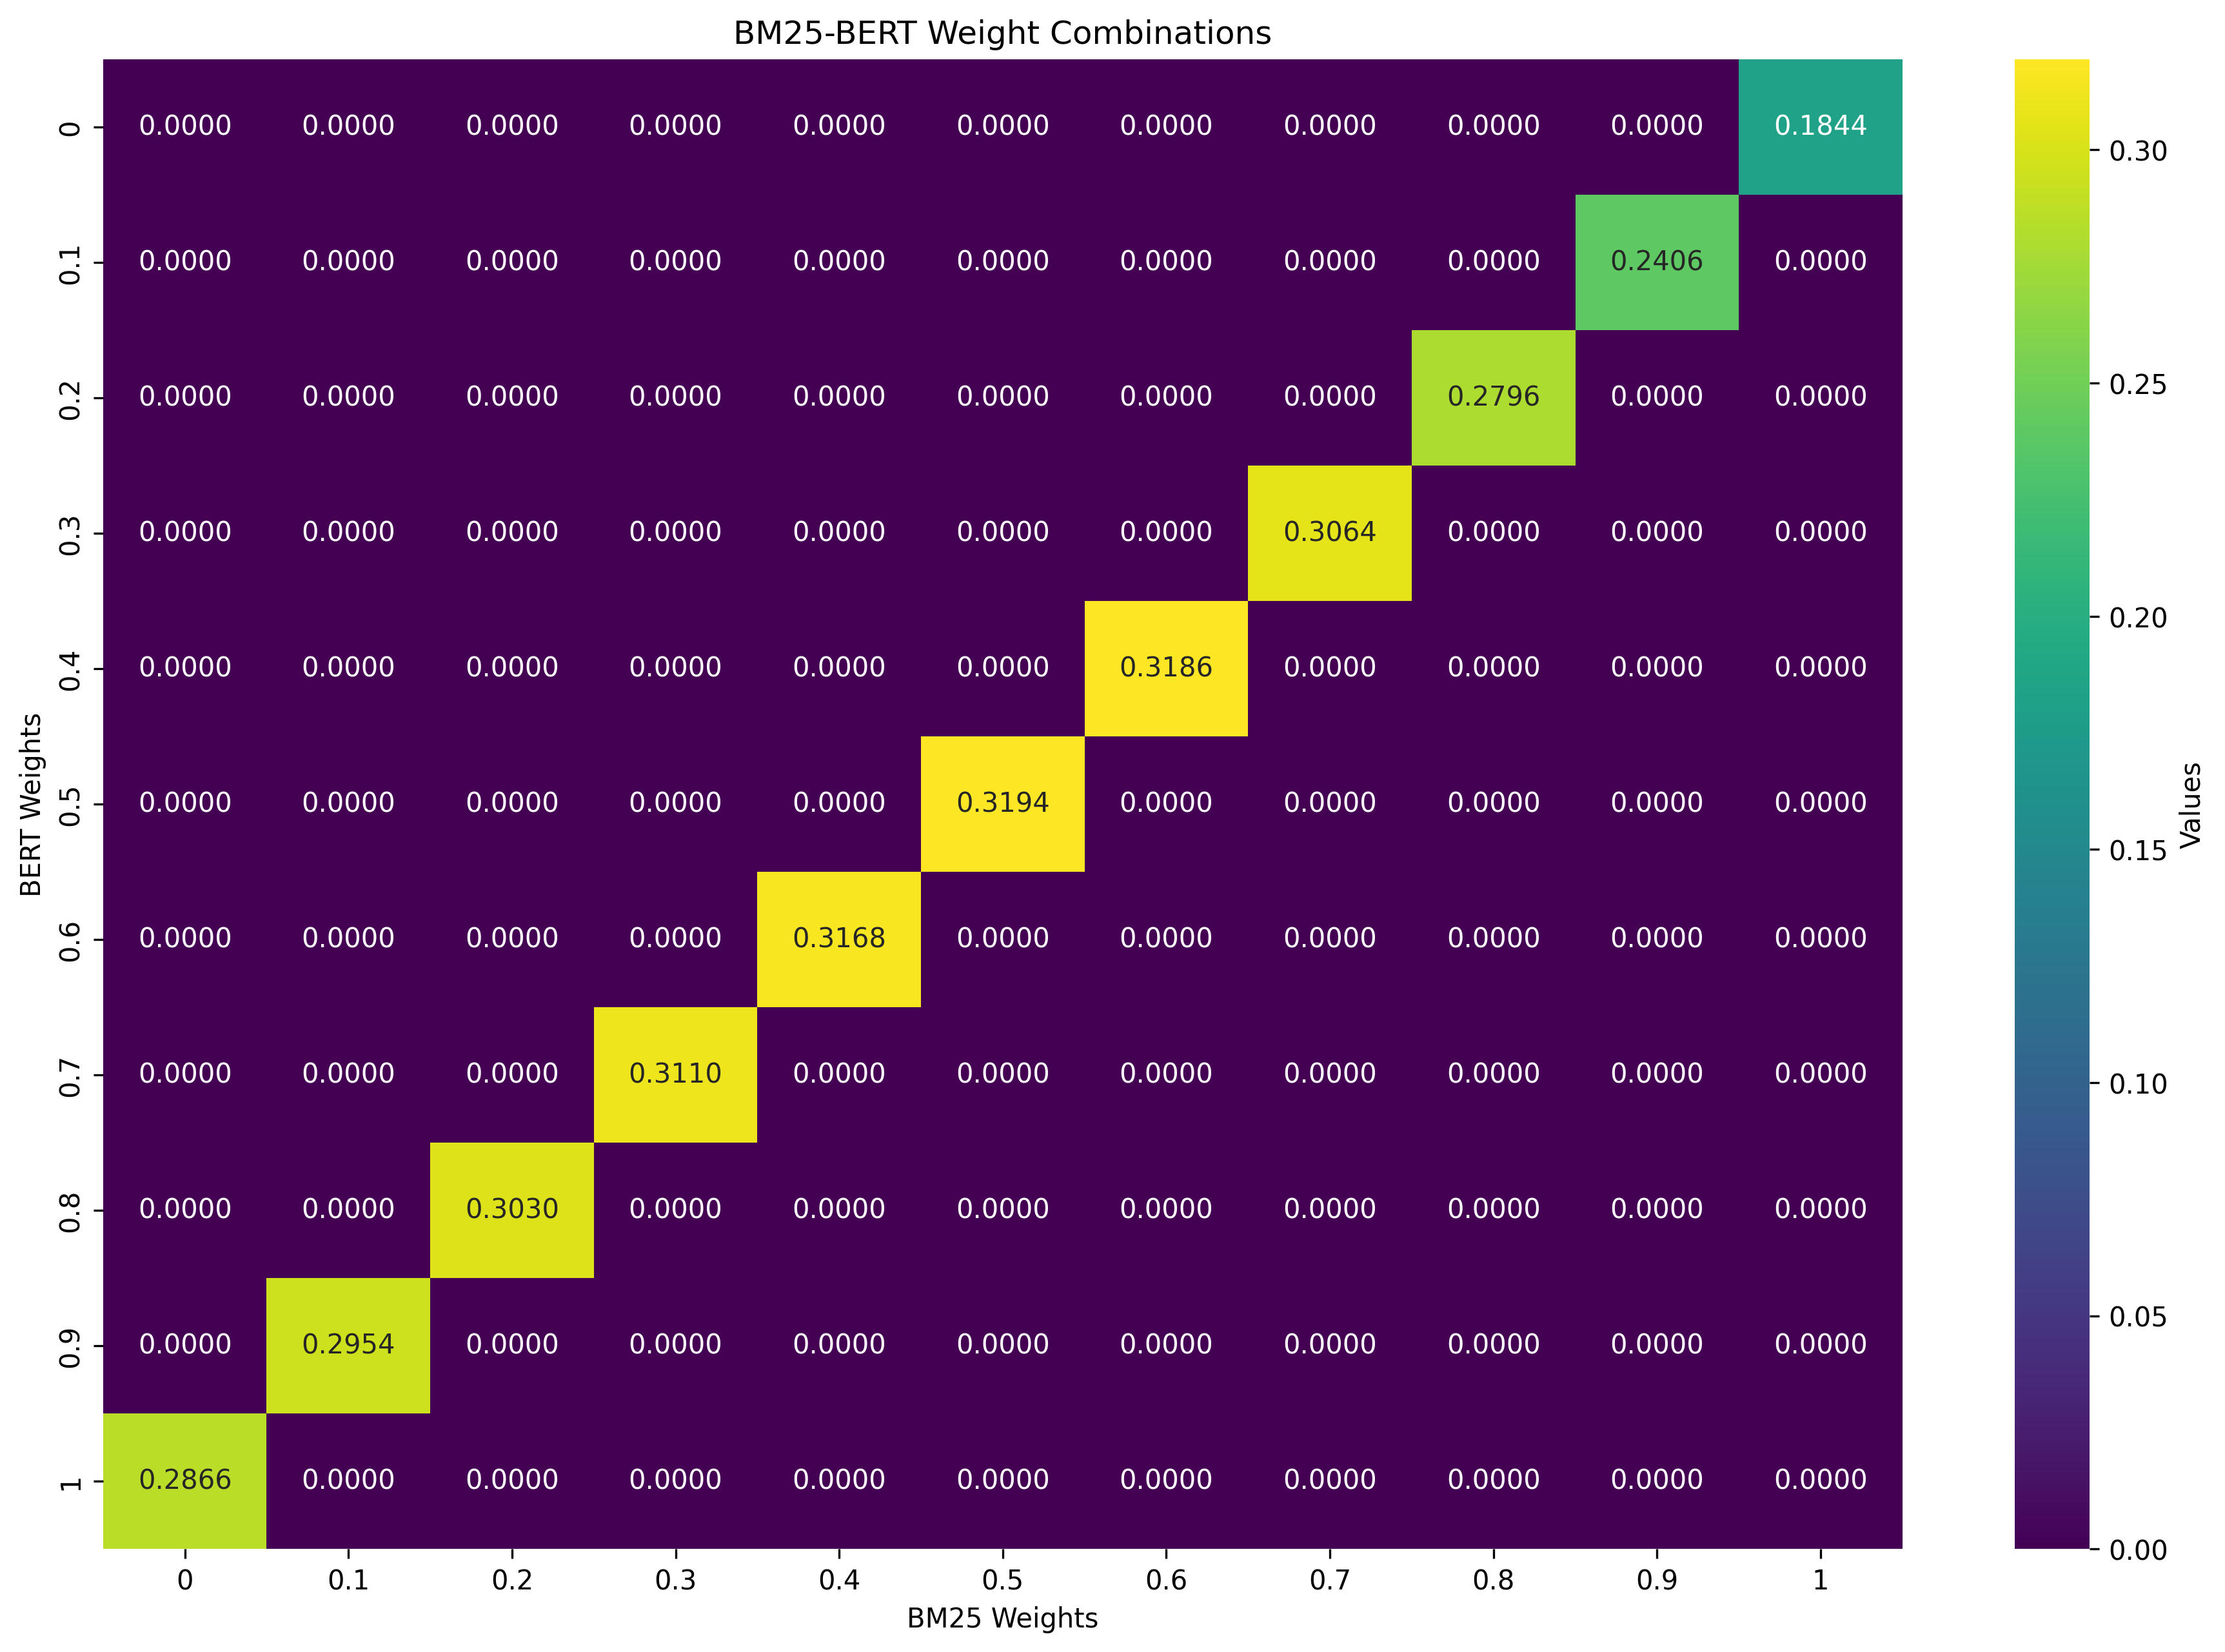

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your data
data = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1844],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2406, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0.2796, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0.3064, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0.3186, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0.3194, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0.3168, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0.311, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0.303, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0.2954, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0.2866, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

plt.figure(figsize=(15, 10), dpi=300)

mask = data == 0.
# Create a heatmap
sns.heatmap(data, cmap="viridis", annot=True, fmt=".4f", cbar_kws={'label': 'Values'}, xticklabels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], yticklabels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xlabel("BM25 Weights")
plt.ylabel("BERT Weights")
plt.title("BM25-BERT Weight Combinations")
plt.show()

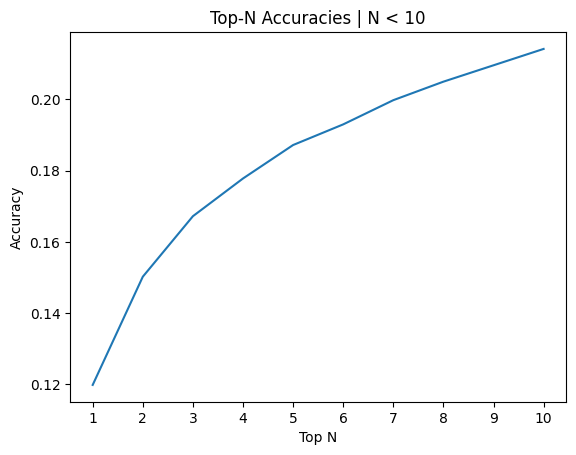

In [143]:
import matplotlib.pyplot as plt

top_accuracies = []
max_length = 10

for i in range(1, max_length + 1):
    top_accuracy = (results <= i).mean(axis=0)
    top_accuracies.append(top_accuracy)

plt.plot(range(1, max_length + 1), np.array(top_accuracies)[:, 5])
plt.xlabel('Top N')
plt.xticks(np.arange(10) + 1)
plt.ylabel('Accuracy')
plt.title('Top-N Accuracies | N < 10')
plt.show()

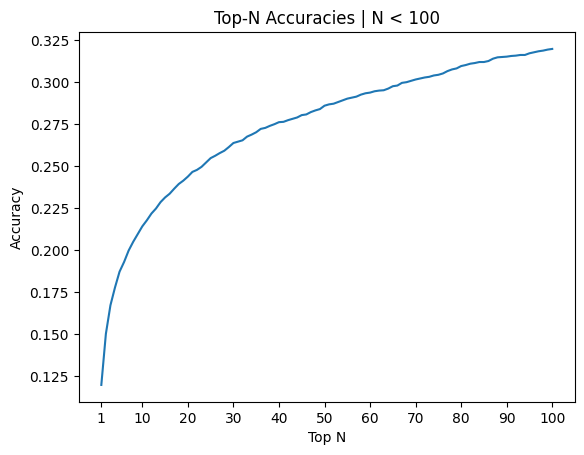

In [144]:
import matplotlib.pyplot as plt

top_accuracies = []
max_length = 100

for i in range(1, max_length + 1):
    top_accuracy = (results <= i).mean(axis=0)
    top_accuracies.append(top_accuracy)

plt.plot(range(1, max_length + 1), np.array(top_accuracies)[:, 5])
plt.xlabel('Top N')
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.ylabel('Accuracy')
plt.title('Top-N Accuracies | N < 100')
plt.show()

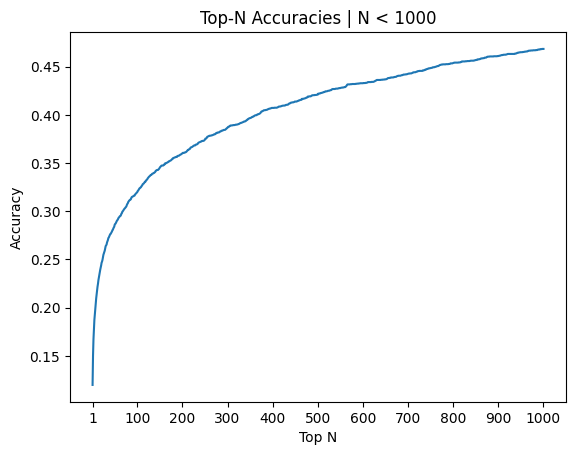

In [145]:
import matplotlib.pyplot as plt

top_accuracies = []
max_length = 1000

for i in range(1, max_length + 1):
    top_accuracy = (results <= i).mean(axis=0)
    top_accuracies.append(top_accuracy)

plt.plot(range(1, max_length + 1), np.array(top_accuracies)[:, 5])
plt.xlabel('Top N')
plt.xticks([1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
plt.ylabel('Accuracy')
plt.title('Top-N Accuracies | N < 1000')
plt.show()